In [1]:
import os
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [3]:
def data_gen():
    train_gen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    validation_gen = ImageDataGenerator(
        rescale=1/255
    )
    
    train_datagen = train_gen.flow_from_directory(
        'Animals/training',
        target_size=(300,300),
        batch_size=32,
        class_mode='categorical'
    )
    validation_datagen = validation_gen.flow_from_directory(
        'Animals/validation',
        target_size=(300,300),
        batch_size=32,
        class_mode='categorical'
    )
    
    return train_datagen, validation_datagen

In [4]:
def create_own_model():
    model = keras.Sequential([
        # CONV => RELU => BN => POOL => DO
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(300, 300, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3,3),
        layers.Dropout(0.25),
        
        # (CONV => RELU => BN)*2 => POOL => DO
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        
        # (CONV => RELU => BN)*2 => POOL => DO
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        
        # (FC => RELU => BN => DO)*2 => FC => SOFTMAX
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model
    

In [5]:
def create_transfer_learning_model():
    base_model = InceptionV3(
        input_shape=(300,300,3),
        include_top=False,
        weights='imagenet'
    )
    
    for layer in base_model.layers:
        layer.trainable = False
    
    head_model = base_model.output
    head_model = layers.Flatten()(head_model)
    head_model = layers.Dense(1024, activation='relu')(head_model)
    head_model = layers.BatchNormalization()(head_model)
    head_model = layers.Dropout(0.25)(head_model)
    head_model = layers.Dense(512, activation='relu')(head_model)
    head_model = layers.BatchNormalization()(head_model)
    head_model = layers.Dropout(0.5)(head_model)
    
    head_model = layers.Dense(3, activation='softmax')(head_model)
    
    model = Model(inputs=base_model.input, outputs=head_model)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [6]:
def create_callbacks():
    callback_1 = EarlyStopping(monitor='val_acc', patience=4)
    callback_2 = ModelCheckpoint(
        'Animals_ModelCheckpoints/model-{epoch:02d}-{val_acc:.2f}.hdf5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_acc',
        save_freq='epoch',
        mode='auto',
        verbose=1
    )

    return [callback_1, callback_2]

In [10]:
def plot_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10,6))
    epoch = range(len(acc))
    
    plt.plot(epoch, acc, 'r', label='Training Accuracy')
    plt.plot(epoch, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epoch, loss, 'g', label='Training Loss')
    plt.plot(epoch, val_loss, 'y', label='Validation Loss')
    
    plt.title('Training & Validation, Accuracy & Loss')
    plt.legend(loc=0)
    plt.show()

In [8]:
model = create_own_model()
training_datagen, validation_datagen = data_gen()
history = model.fit(
    training_datagen,
    epochs=30,
    validation_data=validation_datagen,
    callbacks=create_callbacks(),
    verbose=1
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.2381 - acc: 0.5292
Epoch 00001: val_acc improved from -inf to 0.33333, saving model to Animals_ModelCheckpoints/model-01-0.33.hdf5
75/75 [==============================] - 40s 533ms/step - loss: 1.2381 - acc: 0.5292 - val_loss: 4.0135 - val_acc: 0.3333
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.8709 - acc: 0.6042
Epoch 00002: val_acc did not improve from 0.33333
75/75 [==============================] - 40s 533ms/step - loss: 0.8709 - acc: 0.6042 - val_loss: 3.9076 - val_acc: 0.3333
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.8323 - acc: 0.6008
Epoch 00003: val_acc improved from 0.33333 to 0.35000, saving model to Animals_ModelCheckpoints/model-03-0.35.hdf5
75/75 [==============================] - 40s 535ms/step - loss: 0.8323 - acc: 0.6008 - val_loss: 3.0383 - val_acc: 0.3500
Epoch 4

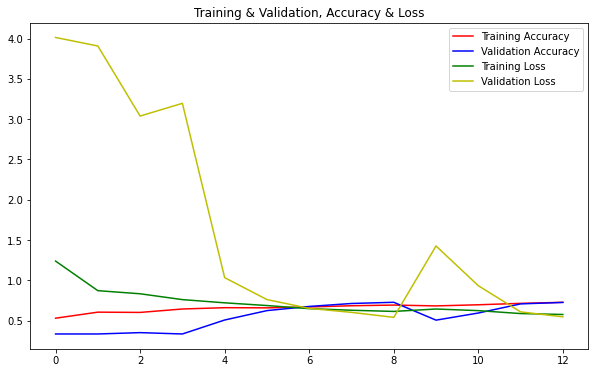

In [11]:
plot_graph(history)

In [12]:
model = create_transfer_learning_model()
training_datagen, validation_datagen = data_gen()

history = model.fit(
    training_datagen,
    validation_data=validation_datagen,
    epochs=30,
    callbacks=create_callbacks(),
    verbose=1
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.1724 - acc: 0.9525
Epoch 00001: val_acc improved from -inf to 0.95667, saving model to Animals_ModelCheckpoints/model-01-0.96.hdf5
75/75 [==============================] - 41s 548ms/step - loss: 0.1724 - acc: 0.9525 - val_loss: 0.2077 - val_acc: 0.9567
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.1153 - acc: 0.9679
Epoch 00002: val_acc improved from 0.95667 to 0.99167, saving model to Animals_ModelCheckpoints/model-02-0.99.hdf5
75/75 [==============================] - 42s 559ms/step - loss: 0.1153 - acc: 0.9679 - val_loss: 0.0331 - val_acc: 0.9917
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0719 - acc: 0.9771
Epoch 00003: val_acc improved from 0.99167 to 0.99333, saving model to Animals_ModelCheckpoints/model-03-0.99.hdf5
75/75 [==============================] - 42s 557ms/step - loss: 

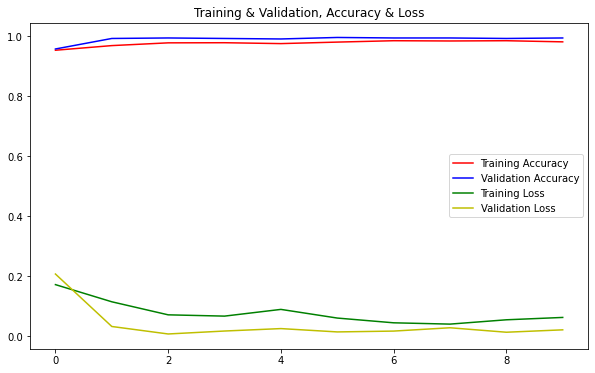

In [13]:
plot_graph(history)